In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

# # Create a new YOLO model from scratch
# model = YOLO('yolov8n.yaml')

# Load a pretrained YOLO model (recommended for training)
# model = YOLO('yolov8n.pt')
model = YOLO('yolov8s-seg.pt')


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pathlib
# local
from utils import get_frames, get_labels_df, draw_bboxes

In [ ]:
# Plan of action
# 1 Load images
# 2 match features in left and right images
# 3 get bboxes for the relvant object from YOLO
# 4 identofy KFs inside bboxes from YOLO

In [ ]:
# 1 load left and right images

# get frames from sequence 1
frame_num = 0
frame_r, frame_l = get_frames(frame_num, pathlib.Path('./seq_01/')) # frames come already in RGB format

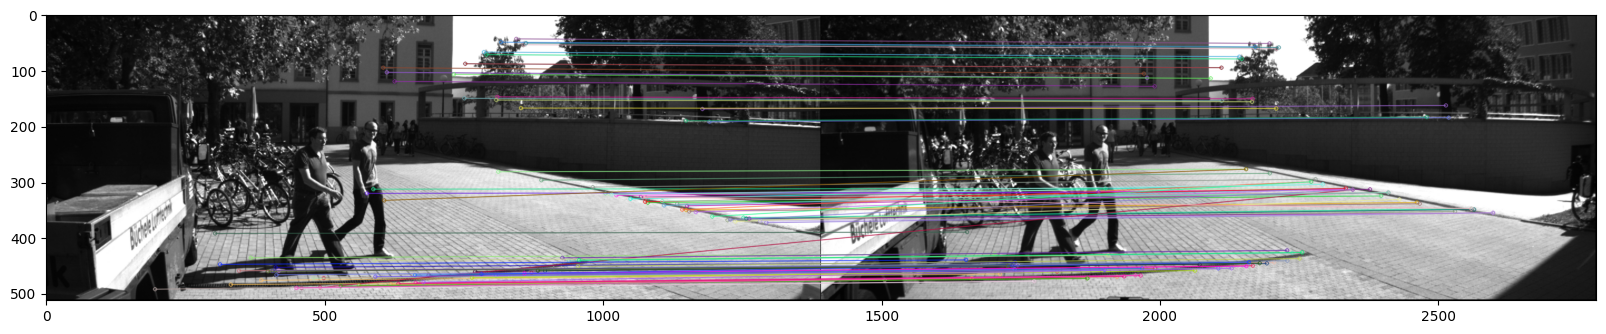

In [ ]:
# 2 match features in left and right images

# Detecting features and matching them
# feature detection
gray_r = cv.cvtColor(frame_r,cv.COLOR_RGB2GRAY)
gray_l = cv.cvtColor(frame_l,cv.COLOR_RGB2GRAY)

# match features between right and left frame with sift and brute force matcher
sift = cv.SIFT_create()
bf = cv.BFMatcher()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray_r,None)
kp2, des2 = sift.detectAndCompute(gray_l,None)

# match descriptors
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv.drawMatches(gray_r,kp1,gray_l,kp2,matches[:100],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize = (20,20))
plt.imshow(img3)

In [ ]:
# 3 get bboxes for the relvant object from YOLO

# predicting on both frames
results = model.predict([frame_l, frame_r])

# plotting all recognitions
# annotated_frame = results[0].plot()
# plt.figure()
# plt.imshow(annotated_frame)

# retrieving ids of interest
ids_of_interest = [
    0, # person
    2, # car
    5 # bus
]

# Get relevant ids - usually known
# for id, name in results[0].names.items():
#   if name in ("person", "car", "bus"):
#     print(f"{name} has id {id}")
#     ids_of_interest.append(id)


def retrieve_cls_details(result_, cls_id_):
  """
  return the bounding boxes coordinates and confidence values for all the object of a given class id,
  from a single result (frame) of the output of the ultralytics.model.predict()
  
  """
  _cls_ids = np.argwhere(result_.boxes.cls==cls_id_)  # find objects of class coi
  if _cls_ids == None: return 
  cls_bboxes = result_.boxes.xyxy[_cls_ids][0,:,:] # for some reason there is another dimension of size 1 (1,N,4)
  cls_conf = result_.boxes.conf[_cls_ids]

  return cls_bboxes, cls_conf


person_bboxes, person_conf = retrieve_cls_details(results[0], 0)


0: 256x640 3 persons, 2 bicycles, 1 bus, 1: 256x640 3 persons, 2 bicycles, 1 bus, 1 truck, 205.7ms
Speed: 0.9ms preprocess, 102.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


REMEMBER: bboxes are with respect to the left frame
REMEMBER: bboxes are with respect to the left frame


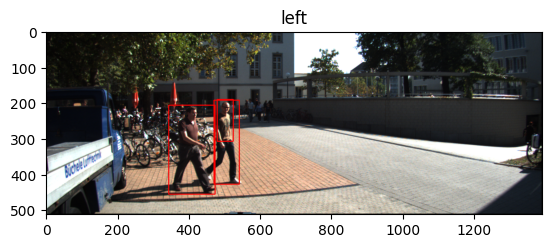

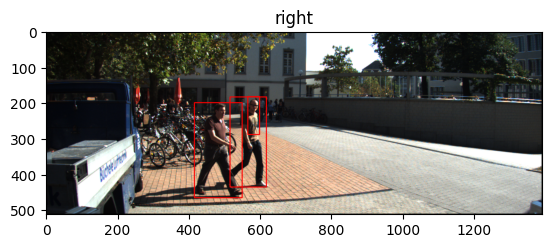

In [ ]:
person_bboxes_l, person_conf_l = retrieve_cls_details(results[0], 0)
person_bboxes_r, person_conf_r = retrieve_cls_details(results[1], 0)

marked_frame_l = draw_bboxes(frame_l, person_bboxes_l)
marked_frame_r = draw_bboxes(frame_r, person_bboxes_r)

plt.figure()
plt.imshow(marked_frame_l)
plt.title('left')
plt.show()
plt.imshow(marked_frame_r)
plt.title('right')
plt.show()


0: 256x640 7 persons, 2 bicycles, 1 truck, 1: 256x640 6 persons, 3 bicycles, 1 truck, 936.7ms
Speed: 0.7ms preprocess, 468.4ms inference, 38.5ms postprocess per image at shape (1, 3, 640, 640)


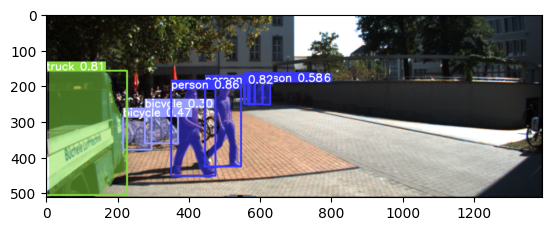

In [ ]:
# predicting on both frames
results = model.predict([frame_l, frame_r])

# plotting all recognitions
annotated_frame = results[0].plot()
plt.figure()
plt.imshow(annotated_frame)

In [ ]:
# print(results[0].masks.shape)

def retrieve_cls_details(result_, cls_id_):
  """
  return the bounding boxes coordinates, confidence and mask values for all the object of a given class id,
  from a single result (frame) of the output of the ultralytics.model.predict()
  
  """
  _cls_ids = np.argwhere(result_.boxes.cls==cls_id_)  # find objects of class coi
  if _cls_ids == None: return 
  cls_bboxes = result_.boxes.xyxy[_cls_ids][0,:,:] # for some reason there is another dimension of size 1 (1,N,4)
  cls_conf = result_.boxes.conf[_cls_ids]
  cls_masks = result_.masks[_cls_ids][0,:,:] # for some reason there is another dimension of size 1 (1,N,4)

  return cls_bboxes, cls_conf, cls_masks

cls_bboxes, cls_conf, cls_masks = retrieve_cls_details(results[0], 0)

(256, 640)


ValueError: ignored

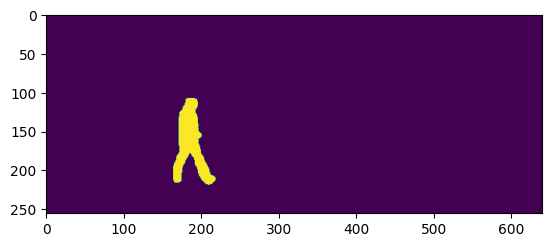

In [ ]:
m_p1 = cls_masks[0].data[0,:,:].numpy()
plt.figure()
plt.imshow(m_p1.astype(bool))



In [ ]:
img_og = results[0].orig_img

print(img_og.shape, m_p1.shape)
# object_pixels = cv.bitwise_and(frame_l, frame_l, mask=m_p1)

# Display the object pixels
# plt.figure()
# plt.imshow('Object Pixels', object_pixels)

(512, 1392, 3) (256, 640)


In [ ]:
black = np.zeros_like(frame_l)
print(black.shape)
# black = black[m_p1.astype(bool)]

# plt.figure()
# plt.imshow(black)

(512, 1392, 3)
